In [1]:
# 0. Import et initialisation SparkSession
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_timestamp, expr, month, dayofyear, countDistinct, count, avg, min, max

spark = SparkSession.builder \
    .appName("Citibike Analysis 2016") \
    .getOrCreate()

import os

In [2]:
# 1. Chargement des fichiers CSV en concaténant tous les fichiers dans un dossier
base_path = "C:/Users/USER/2016-citibike-tripdata"  # ← à adapter
csv_paths = []
for root, dirs, files in os.walk(base_path):
    for file in files:
        if file.endswith(".csv"):
            csv_paths.append(os.path.join(root, file))

tripdataDF = spark.read.csv(csv_paths, header=True, inferSchema=True)

In [23]:
# 2. Comprendre la structure des données
print("=== Schéma des données ===")
tripdataDF.printSchema()

print("=== Aperçu des premières lignes ===")
tripdataDF.show(5, truncate=False)

print("Nombre total de lignes :", tripdataDF.count())

=== Schéma des données ===
root
 |-- Trip Duration: string (nullable = true)
 |-- Start Time: string (nullable = true)
 |-- Stop Time: string (nullable = true)
 |-- Start Station ID: string (nullable = true)
 |-- Start Station Name: string (nullable = true)
 |-- Start Station Latitude: string (nullable = true)
 |-- Start Station Longitude: string (nullable = true)
 |-- End Station ID: string (nullable = true)
 |-- End Station Name: string (nullable = true)
 |-- End Station Latitude: string (nullable = true)
 |-- End Station Longitude: string (nullable = true)
 |-- Bike ID: string (nullable = true)
 |-- User Type: string (nullable = true)
 |-- Birth Year: string (nullable = true)
 |-- Gender: string (nullable = true)

=== Aperçu des premières lignes ===
+-------------+-------------------+-------------------+----------------+-----------------------+----------------------+-----------------------+--------------+----------------------------+--------------------+---------------------+-------

In [31]:
print("Nombre total de lignes :", tripdataDF.count())

# Liste des formats à tester
date_formats = [
    "yyyy-MM-dd HH:mm:ss",
    "MM/dd/yyyy HH:mm",
    "MM/dd/yyyy HH:mm:ss",
    "M/d/yyyy HH:mm:ss"
]

# Fonction qui applique try_to_timestamp sur plusieurs formats
def try_parse_multiple_formats(col_name):
    # crée une expression SQL qui essaie les formats en try_to_timestamp
    exprs = [f"try_to_timestamp(`{col_name}`, '{fmt}')" for fmt in date_formats]
    # coalesce prend la première valeur non nulle
    return expr("coalesce(" + ", ".join(exprs) + ")")

# Conversion des colonnes avec try_to_timestamp
tripdata = tripdataDF.select(
    expr("try_cast(`Trip Duration` as int)").alias("tripduration"),
    try_parse_multiple_formats("Start Time").alias("starttime"),
    try_parse_multiple_formats("Stop Time").alias("stoptime"),
    col("Start Station ID").alias("start_station_id"),
    col("Start Station Name").alias("start_station_name"),
    col("Start Station Latitude").cast("double").alias("start_lat"),
    col("Start Station Longitude").cast("double").alias("start_long"),
    col("End Station ID").alias("end_station_id"),
    col("End Station Name").alias("end_station_name"),
    col("End Station Latitude").cast("double").alias("end_lat"),
    col("End Station Longitude").cast("double").alias("end_long"),
    col("Bike ID").alias("bikeid"),
    col("User Type").alias("usertype"),
    expr("try_cast(`Birth Year` as int)").alias("birthyear"),
    col("Gender").cast("int").alias("gender")
)

tripdata_clean = tripdata.filter(
    (col("tripduration") > 0) & 
    col("starttime").isNotNull() & 
    col("stoptime").isNotNull()
)

tripdata_clean.cache()

print("=== Aperçu après prétraitement et nettoyage ===")
tripdata_clean.show(5, truncate=False)

print("Nombre total de lignes après nettoyage :", tripdata_clean.count())


Nombre total de lignes : 13845655
=== Aperçu après prétraitement et nettoyage ===
+------------+-------------------+-------------------+----------------+-----------------------+-----------+------------+--------------+----------------------------+-----------+--------------+------+----------+---------+------+
|tripduration|starttime          |stoptime           |start_station_id|start_station_name     |start_lat  |start_long  |end_station_id|end_station_name            |end_lat    |end_long      |bikeid|usertype  |birthyear|gender|
+------------+-------------------+-------------------+----------------+-----------------------+-----------+------------+--------------+----------------------------+-----------+--------------+------+----------+---------+------+
|328         |2016-10-01 00:00:07|2016-10-01 00:05:35|471             |Grand St & Havemeyer St|40.71286844|-73.95698119|3077          |Stagg St & Union Ave        |40.70877084|-73.95095259  |25254 |Subscriber|NULL     |1     |
|398      

+----+-------+
|mois|  count|
+----+-------+
|   1| 509478|
|   2| 560874|
|   3| 919921|
|   4|1013149|
|   5|1212280|
|   6|1460318|
|   7|1380110|
|   8|1557663|
|   9|1648856|
|  10|1573872|
|  11|1196942|
|  12| 812192|
+----+-------+



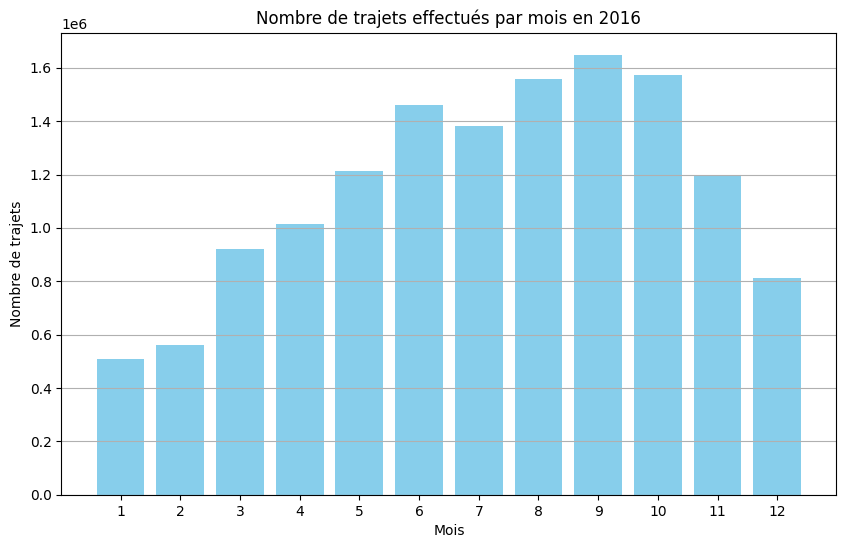

In [32]:

# 3. Nombre de trajets effectués par mois et diagramme en bâtons (utilise matplotlib si possible)

from matplotlib import pyplot as plt

trajets_par_mois = tripdata_clean.withColumn("mois", month("starttime")) \
    .groupBy("mois") \
    .count() \
    .orderBy("mois")

trajets_par_mois.show()

# Conversion en pandas pour tracé matplotlib
trajets_pd = trajets_par_mois.toPandas()

plt.figure(figsize=(10,6))
plt.bar(trajets_pd['mois'], trajets_pd['count'], color='skyblue')
plt.xlabel("Mois")
plt.ylabel("Nombre de trajets")
plt.title("Nombre de trajets effectués par mois en 2016")
plt.xticks(trajets_pd['mois'])
plt.grid(axis='y')
plt.show()


+----+-----+
|jour|count|
+----+-----+
|   1|11009|
|   2|14587|
|   3|15499|
|   4|19593|
|   5|18053|
|   6|24569|
|   7|27773|
|   8|28709|
|   9|20846|
|  10|14275|
|  11|22937|
|  12|25211|
|  13|21133|
|  14|23780|
|  15|28435|
|  16|19178|
|  17|12024|
|  18|12718|
|  19|17281|
|  20|23420|
+----+-----+
only showing top 20 rows


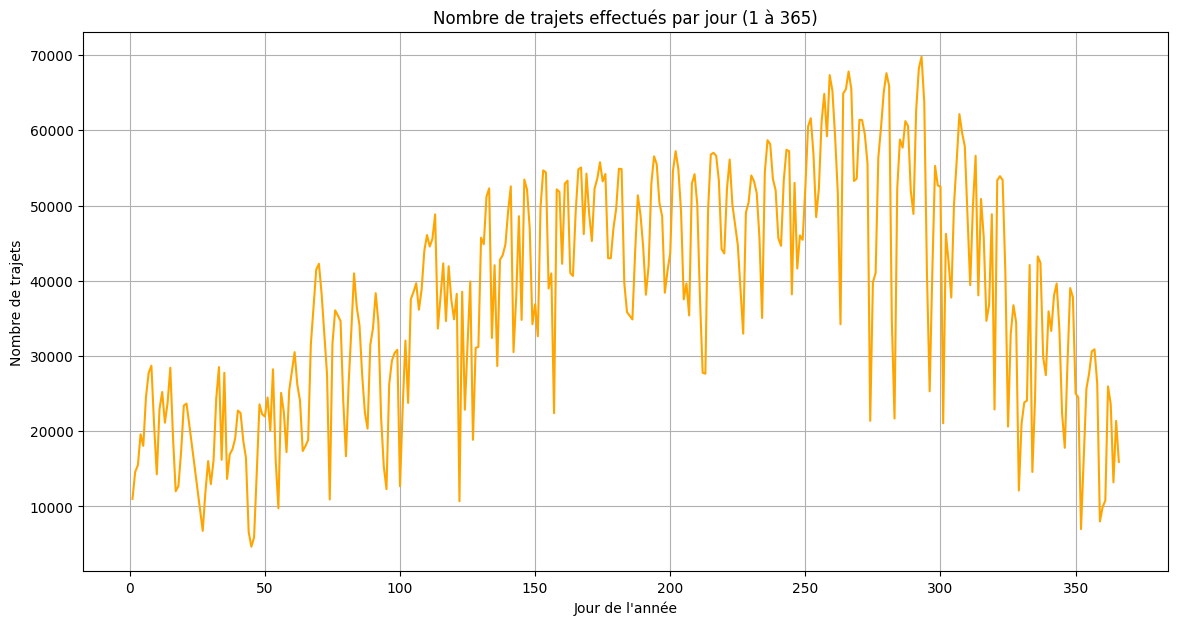

In [33]:
# 4. Nombre de trajets effectués par jour (jour de l'année) et tracé courbe

trajets_par_jour = tripdata_clean.withColumn("jour", dayofyear("starttime")) \
    .groupBy("jour") \
    .count() \
    .orderBy("jour")

trajets_par_jour.show()

trajets_jour_pd = trajets_par_jour.toPandas()

plt.figure(figsize=(14,7))
plt.plot(trajets_jour_pd['jour'], trajets_jour_pd['count'], color='orange')
plt.xlabel("Jour de l'année")
plt.ylabel("Nombre de trajets")
plt.title("Nombre de trajets effectués par jour (1 à 365)")
plt.grid(True)
plt.show()


In [34]:
# 5. Pour chaque station de départ et chaque mois, nombre d’utilisateurs distincts (distinct bikeid)

utilisateurs_station_mois = tripdata_clean.withColumn("mois", month("starttime")) \
    .groupBy("start_station_name", "mois") \
    .agg(countDistinct("bikeid").alias("nb_utilisateurs")) \
    .orderBy("start_station_name", "mois")

utilisateurs_station_mois.show(truncate=False)

+------------------+----+---------------+
|start_station_name|mois|nb_utilisateurs|
+------------------+----+---------------+
|1 Ave & E 15 St   |1   |2066           |
|1 Ave & E 15 St   |2   |2235           |
|1 Ave & E 15 St   |3   |3238           |
|1 Ave & E 15 St   |4   |3355           |
|1 Ave & E 15 St   |5   |3680           |
|1 Ave & E 15 St   |6   |4098           |
|1 Ave & E 16 St   |7   |3953           |
|1 Ave & E 16 St   |8   |4192           |
|1 Ave & E 16 St   |9   |12             |
|1 Ave & E 16 St   |10  |2776           |
|1 Ave & E 16 St   |11  |3799           |
|1 Ave & E 16 St   |12  |2857           |
|1 Ave & E 18 St   |1   |1580           |
|1 Ave & E 18 St   |2   |1717           |
|1 Ave & E 18 St   |3   |2506           |
|1 Ave & E 18 St   |4   |2461           |
|1 Ave & E 18 St   |5   |2792           |
|1 Ave & E 18 St   |6   |3205           |
|1 Ave & E 18 St   |7   |3065           |
|1 Ave & E 18 St   |8   |3288           |
+------------------+----+---------

+------------------------+-----+
|start_station_name      |count|
+------------------------+-----+
|Pershing Square North   |38631|
|Cooper Square & E 7 St  |26237|
|W 21 St & 6 Ave         |24350|
|E 17 St & Broadway      |23895|
|Broadway & E 22 St      |23486|
|8 Ave & W 33 St         |21831|
|Broadway & E 14 St      |21742|
|W 41 St & 8 Ave         |21382|
|West St & Chambers St   |19957|
|E 47 St & Park Ave      |19815|
|8 Ave & W 31 St         |18937|
|W 52 St & 5 Ave         |18772|
|W 38 St & 8 Ave         |18399|
|Cleveland Pl & Spring St|18097|
|Broadway & W 24 St      |18086|
|Greenwich Ave & 8 Ave   |17942|
|W 31 St & 7 Ave         |17709|
|Carmine St & 6 Ave      |17662|
|Central Park S & 6 Ave  |17144|
|9 Ave & W 22 St         |16892|
+------------------------+-----+
only showing top 20 rows


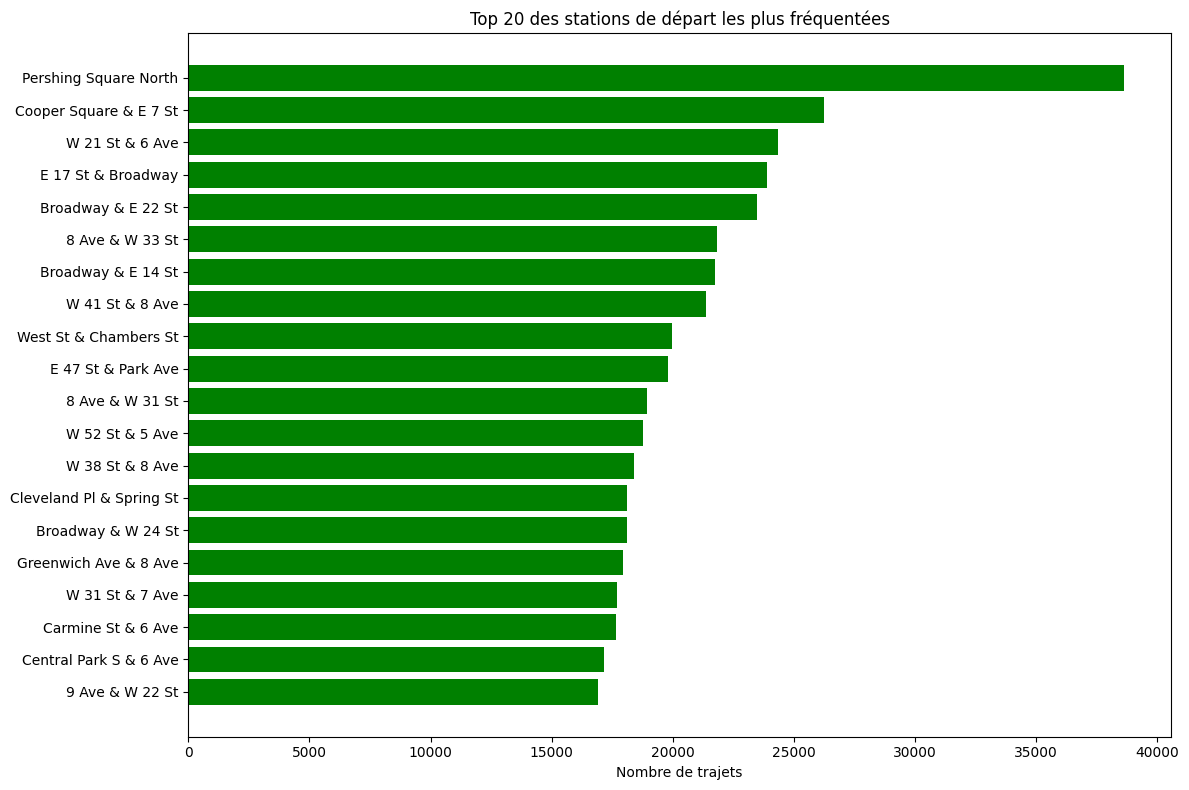

In [8]:
# 6. 
# Taux de fréquentation pour chaque station de départ (nombre de trajets depuis cette station)
# puis représentation graphique simple (ex: top 20 stations)

freq_station = tripdata_clean.groupBy("start_station_name") \
    .count() \
    .orderBy(col("count").desc())

freq_station.show(20, truncate=False)

# Tracé en barres du top 20 des stations les plus fréquentées
freq_station_top20 = freq_station.limit(20).toPandas()

plt.figure(figsize=(12,8))
plt.barh(freq_station_top20['start_station_name'][::-1], freq_station_top20['count'][::-1], color='green')
plt.xlabel("Nombre de trajets")
plt.title("Top 20 des stations de départ les plus fréquentées")
plt.tight_layout()
plt.show()


In [35]:
# 7. Durée moyenne, minimale et maximale par trajet identifié (ici on prend Bike ID comme identifiant trajet)

stats_duree = tripdata_clean.groupBy("bikeid") \
    .agg(
        avg("tripduration").alias("duree_moyenne"),
        min("tripduration").alias("duree_minimale"),
        max("tripduration").alias("duree_maximale")
    ) \
    .orderBy("bikeid")

stats_duree.show(20, truncate=False)

+------+------------------+--------------+--------------+
|bikeid|duree_moyenne     |duree_minimale|duree_maximale|
+------+------------------+--------------+--------------+
|14529 |915.8745980707396 |61            |44539         |
|14530 |1058.2666666666667|75            |163227        |
|14531 |966.5303703703704 |65            |64856         |
|14532 |898.8239700374531 |65            |35073         |
|14533 |878.0714285714286 |61            |12637         |
|14534 |1049.3375277572168|62            |119596        |
|14535 |984.3955014058107 |69            |61262         |
|14536 |995.4669039145907 |71            |64739         |
|14537 |902.6802403204273 |61            |14335         |
|14538 |1435.72265625     |64            |143662        |
|14539 |907.1606694560669 |65            |26470         |
|14540 |1248.3829611248966|64            |312563        |
|14541 |948.0202360876897 |69            |52850         |
|14544 |919.0118613138686 |71            |23576         |
|14545 |1900.0